In [1]:
import autograd.numpy as np
from autograd.scipy.stats import norm
from autograd import grad, hessian

import time

import matplotlib.pyplot as plt

from minimize import kalman_filter_smoother, post_pred, log_expected_improvement, newton

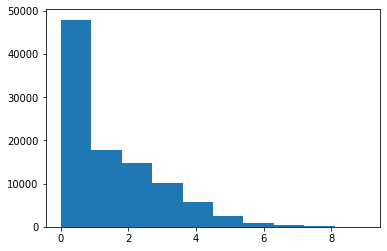

1.3989872454027326
1.3955931148026122
1.3955931148026122


In [2]:
num_samples = int(1e5)
f0 = 1.
loc = 0.
scale = 2.

f = np.random.normal(loc=loc, scale=scale, size=(num_samples,))
improvement = f0 - f
improvement = np.max([improvement, np.zeros_like(improvement)], axis=0)

plt.hist(improvement)
plt.show()

z = (f0 - loc) /scale
mean_improvement = np.mean(improvement)
expected_improvement = scale * (z * norm.cdf(z) + norm.pdf(z))
expected_improvement_ = (f0 - loc) * norm.cdf((f0 - loc) / scale) + scale * norm.pdf((f0 - loc) / scale)
print(mean_improvement)
print(expected_improvement)
print(expected_improvement_)

# Approximate log EI



In [3]:
log_ei = lambda z, scale : np.log(scale * (z * norm.cdf(z) + norm.pdf(z)))

In [4]:
def approx_log_ei(z, scale):
    
    cdf_term = - 0.5 * np.log(2 * np.pi) - 0.5 * z ** 2
    hopital_term = - np.log(z ** 2 - 1)
    
    return cdf_term + hopital_term

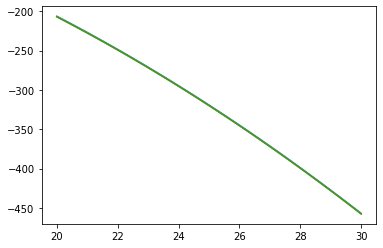

In [5]:
f0 = 1.
scale = 2.
zs = np.linspace(-20., -30, 100)

exact = [log_ei(z, scale) for z in zs]
approx = [approx_log_ei(z, scale) for z in zs]
approx_ = [log_expected_improvement(f0=f0, m=(f0 - scale * z), v=scale ** 2) for z in zs]

plt.plot(-zs, exact)
plt.plot(-zs, approx)
plt.plot(-zs, approx_)
plt.show()

# Fitting data and computing the log EI

In [89]:
def sample_sine_data(t, omega, R):
    
    noise = R[0, 0]
    
    x = np.array([np.sin(omega * t), omega * np.cos(omega * t), - omega ** 2 * np.sin(omega * t)]).T
    y = x[:, :2]
    y[:, 0] = y[:, 0] + noise ** 0.5 * np.random.normal(size=y[:, 0].shape)
    
    return x, y

In [90]:
def line_post_pred(t_data, ms, Vs, CV):

    t = []
    mean = []
    var = []

    for i in range(t_data.shape[0]-1):
        
        dt = t_data[i+1] - t_data[i]

        for a in np.linspace(1e-2, 1 - 1e-2, 10):
            
            dt1 = a * dt
            dt2 = (1 - a) * dt

            mean_, var_ = post_pred(dt1=dt1,
                                    m1=ms[i],
                                    V1=Vs[i],
                                    dt2=dt2,
                                    m2=ms[i+1],
                                    V2=Vs[i+1],
                                    CV=CV[i])
            
            t.append(t_data[i] + dt1)
            mean.append(mean_)
            var.append(np.diag(var_))
            
    mean = np.array(mean)
    var = np.array(var)
            
    return t, mean, var

In [91]:
# Dimensions of the latent and observed spaces
x_dim = 3
y_dim = 2

# Initial distribution matrices
m0 = np.array([0, -1, -2])
S0 = 1e-2 * np.eye(x_dim)

# Set the random seed for comparable figures
np.random.seed(2)

# Define matrices A, Q (dynamics)
num_points = 2
t = np.linspace(0, 10, num_points) + np.cumsum(np.random.rand(num_points))
omega = 0.

# Overal variance parameter θ and log noise to signal ratio
theta2 = 1.
log_nsr = -4.

# Define matrices C, R (data emission)
C = np.eye(3)[:2, :]
R = np.array([[np.exp(log_nsr) * theta2, 0],
              [0,                        0]])

# Sample points
x, y = sample_sine_data(t=t, omega=omega, R=R)

# Do filtering and smoothing
mf, Vf, ms, Vs, CV, theta2, nlml = kalman_filter_smoother(t=t, y=y, log_nsr=log_nsr)

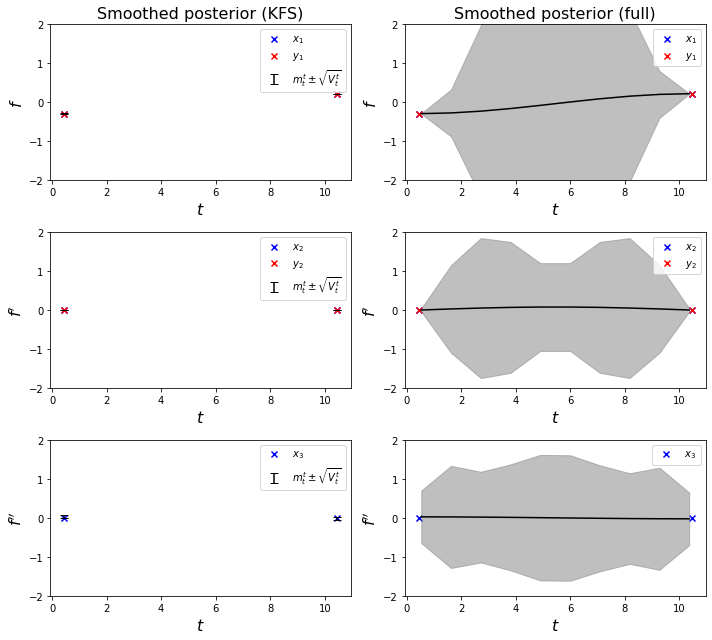

In [92]:
plt.figure(figsize=(10, 9))

for i in range(3):
    
    plt.subplot(3, 2, 2 * i + 1)
    
    plt.scatter(t, x[:, i], marker='x', color='blue', label=r'$x_{}$'.format(i+1))
    
    if i < 2:
        plt.scatter(t, y[:, i], marker='x', color='red', label=r'$y_{}$'.format(i+1))
    if i == 0:
        plt.title('Smoothed posterior (KFS)', fontsize=16)
    
    plt.errorbar(x=t,
                 y=ms[:, i],
                 yerr=2 * Vs[:, i, i] ** 0.5,
                 color='black',
                 zorder=2,
                 fmt="none",
                 label=r"$m_t^t \pm \sqrt{V_t^t}$",
                 capsize=4)
    
    plt.yticks(np.linspace(-2, 2, 5))
    plt.xlabel(r'$t$', fontsize=16)
    plt.legend()
    
    if i == 0:
        plt.ylabel(r'$f$', fontsize=16)
    if i == 1:
        plt.ylabel(r"$f'$", fontsize=16)
    if i == 2:
        plt.ylabel(r"$f''$", fontsize=16)

    plt.subplot(3, 2, 2 * i + 2)
    
    t_, m_, v_ = line_post_pred(t, ms, Vs, CV)
    plt.plot(t_, m_[:, i], color='k')
    plt.scatter(t, x[:, i], marker='x', color='blue', label=r'$x_{}$'.format(i+1))
    
    if i < 2:
        plt.scatter(t, y[:, i], marker='x', color='red', label=r'$y_{}$'.format(i+1))
    if i == 0:
        plt.title('Smoothed posterior (full)', fontsize=16)

    plt.fill_between(t_,
                     m_[:, i] - 2 * v_[:, i] ** 0.5,
                     m_[:, i] + 2 * v_[:, i] ** 0.5,
                     color='gray', alpha=0.5)
    plt.yticks(np.linspace(-2, 2, 5))
    plt.ylim([-2, 2])
    plt.xlabel(r'$t$', fontsize=16)
    plt.legend()
    
    if i == 0:
        plt.ylabel(r'$f$', fontsize=16)
    if i == 1:
        plt.ylabel(r"$f'$", fontsize=16)
    if i == 2:
        plt.ylabel(r"$f''$", fontsize=16)

plt.tight_layout()
plt.show()

In [93]:
def f(t, t_data, ms, Vs, CV):
    
    # Objective value to improve on
    f0 = np.min(ms[:, 0])

    # Index of first datapoint to the right of time t (datapoint 2)
    i = np.searchsorted(t_data, t)

    # dt's from time t to first datapoints to the left and to the right of t
    dt1 = t - t_data[i-1]
    dt2 = t_data[i] - t

    # Posterior predictive at time t
    m, v = post_pred(dt1=dt1, m1=ms[i-1], V1=Vs[i-1], dt2=dt2, m2=ms[i], V2=Vs[i], CV=CV[i-1])

    # Log expected improvement at time t
    log_ei = log_expected_improvement(f0=f0, m=m[0], v=v[0, 0])
    
    return - log_ei

df = grad(f, argnum=0)
ddf = hessian(f, argnum=0)


def objective(t, t_data, ms, Vs, CV):
    
    f_ = f(t, t_data, ms, Vs, CV)
    df_ = df(t, t_data, ms, Vs, CV)
    ddf_ = float(ddf(t, t_data, ms, Vs, CV))
    
    return f_, df_, ddf_

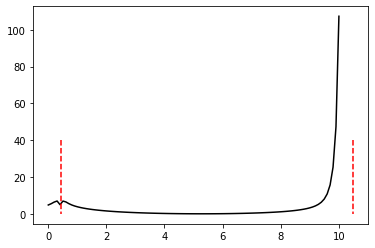

In [94]:
ei_ = [objective(t=t_, t_data=t, ms=ms, Vs=Vs, CV=CV)[0] for t_ in np.linspace(1e-2, 10 - 1e-2, 100)]
plt.plot(np.linspace(1e-2, 10 - 1e-2, 100), ei_, color='k')

for t_ in t:
    plt.plot([t_, t_], [40, 0], '--', color='red')

In [106]:
def newton(objective, budget, t0, tmin, tmax, t_data, ms, Vs, CV):
    
    assert t0 > tmin and t0 < tmax
    
    min_t = tmin + 2e-1 * (tmax - tmin)
    max_t = tmax - 2e-1 * (tmax - tmin)
    f0, df0, ddf0 = objective(t0, t_data, ms, Vs, CV)
    budget = budget - 1
    
    t, f, df, ddf = t0, f0, df0, ddf0
    
    while budget > 1:
        
        # If ddf +ve, then newton is looking for a minimum, so accept it
        if ddf > 0:
            
            # Compute Newton step and ensure it's withing alloed range
            t = t - df / ddf
            t = max(min_t, min(t, max_t))
            
        # Elif df and ddf -ve, move to right boundary
        elif df < 0:
            t = max_t
            
        # Elif df +ve and ddf -ve, move to left boundary
        elif df > 0:
            t = min_t
            
        # If df >= 0.0 we have moved to the left, so update tmax
        if df >= 0.0:
            tmax = t0
        # If df < 0.0 we have moved to the right, so update tmin
        else:
            tmin = t0

        f, df, ddf = objective(t, t_data, ms, Vs, CV)
        budget = budget - 1
        
#         while f > f0:
#             t = (t + t0) / 2
#             print(f'{t}, {t0}, {f}, {f0}')
#             f, df, ddf = objective(t, t_data, ms, Vs, CV)
#             budget = budget - 1
            
        if f < f0:
            t0, f0, df0 = t, f, df
            
        elif t0 == t:
            break
        
    t = min(max(t, min_t), max_t)
    
    f, df, ddf = objective(t, t_data, ms, Vs, CV)
    budget = budget - 1
        
    return t, f

0.2380218505859375 sec taken


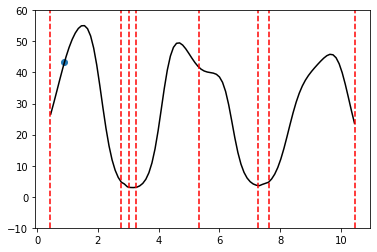

In [107]:
budget = 10
tmin = t[0]
tmax = t[1]
t0 = (tmax - tmin) / 2


wallclock = time.time()
t_opt, f_opt = newton(objective=objective,
                      budget=budget,
                      t0=t0,
                      tmin=tmin,
                      tmax=tmax,
                      t_data=t,
                      ms=ms,
                      Vs=Vs,
                      CV=CV)
print(f'{time.time() - wallclock} sec taken')

eval_times = np.linspace(t[0] + 1e-2, t[-1] - 1e-2, 100)
ei_ = [objective(t=eval_time, t_data=t, ms=ms, Vs=Vs, CV=CV)[0] for eval_time in eval_times]
plt.plot(eval_times, ei_, color='k')

for t_ in t:
    plt.plot([t_, t_], [-10, 60], '--', color='red')
    
plt.ylim([-10, 60])
plt.scatter(t_opt, f_opt)
plt.show()

In [114]:
# Dimensions of the latent and observed spaces
x_dim = 3
y_dim = 2

# Initial distribution matrices
m0 = np.array([0, -1, -2])
S0 = 1e-2 * np.eye(x_dim)

# Set the random seed for comparable figures
np.random.seed(2)

# Define matrices A, Q (dynamics)
num_points = 2
t = np.linspace(0, 10, num_points) + np.cumsum(np.random.rand(num_points))
omega = 1.5

# Overal variance parameter θ and log noise to signal ratio
theta2 = 1.
log_nsr = -2.

# Define matrices C, R (data emission)
C = np.eye(3)[:2, :]
R = np.array([[np.exp(log_nsr) * theta2, 0],
              [0,                        0]])

# Sample points
x, y = sample_sine_data(t=t, omega=omega, R=R)

# Newton budget
budget = 5

for idx in [0, 0, 2, 0, 2, 4, 0, 2, 6, 8, 0, 2, 4, 6, 8, 10]:
    
    mf, Vf, ms, Vs, CV, theta2, nlml = kalman_filter_smoother(t=t, y=y, log_nsr=log_nsr)
    
    tmin = t[idx]
    tmax = t[idx+1]
    t0 = (tmax + tmin) / 2
    
    t_opt, f_opt = newton(objective=objective,
                          budget=budget,
                          t0=t0,
                          tmin=tmin,
                          tmax=tmax,
                          t_data=t,
                          ms=ms,
                          Vs=Vs,
                          CV=CV)
    
    x_new, y_new = sample_sine_data(t=np.array([t_opt]), omega=omega, R=R)
    x_new, y_new = x_new[0], y_new[0]
    
    t = np.insert(t, idx + 1, t_opt)
    
    x = np.insert(x, idx + 1, x_new, axis=0)
    y = np.insert(y, idx + 1, y_new, axis=0)
    
# x, y = sample_sine_data(t=t, omega=omega, R=R)
mf, Vf, ms, Vs, CV, theta2, nlml = kalman_filter_smoother(t=t, y=y, log_nsr=log_nsr)

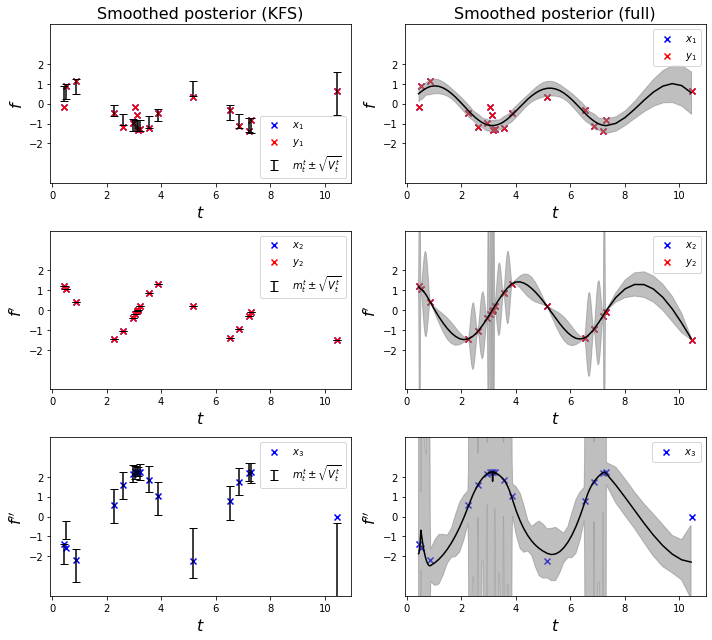

In [115]:
plt.figure(figsize=(10, 9))

for i in range(3):
    
    plt.subplot(3, 2, 2 * i + 1)
    
    plt.scatter(t, x[:, i], marker='x', color='blue', label=r'$x_{}$'.format(i+1))
    
    if i < 2:
        plt.scatter(t, y[:, i], marker='x', color='red', label=r'$y_{}$'.format(i+1))
    if i == 0:
        plt.title('Smoothed posterior (KFS)', fontsize=16)
    
    plt.errorbar(x=t,
                 y=ms[:, i],
                 yerr=2 * Vs[:, i, i] ** 0.5,
                 color='black',
                 zorder=2,
                 fmt="none",
                 label=r"$m_t^t \pm \sqrt{V_t^t}$",
                 capsize=4)
    
    plt.yticks(np.linspace(-2, 2, 5))
    plt.ylim([-4, 4])
    plt.xlabel(r'$t$', fontsize=16)
    plt.legend()
    
    if i == 0:
        plt.ylabel(r'$f$', fontsize=16)
    if i == 1:
        plt.ylabel(r"$f'$", fontsize=16)
    if i == 2:
        plt.ylabel(r"$f''$", fontsize=16)

    plt.subplot(3, 2, 2 * i + 2)
    
    t_, m_, v_ = line_post_pred(t, ms, Vs, CV)
    plt.plot(t_, m_[:, i], color='k')
    plt.scatter(t, x[:, i], marker='x', color='blue', label=r'$x_{}$'.format(i+1))
    
    if i < 2:
        plt.scatter(t, y[:, i], marker='x', color='red', label=r'$y_{}$'.format(i+1))
    if i == 0:
        plt.title('Smoothed posterior (full)', fontsize=16)

    plt.fill_between(t_,
                     m_[:, i] - 2 * v_[:, i] ** 0.5,
                     m_[:, i] + 2 * v_[:, i] ** 0.5,
                     color='gray', alpha=0.5)
    plt.yticks(np.linspace(-2, 2, 5))
    plt.ylim([-4, 4])
    plt.xlabel(r'$t$', fontsize=16)
    plt.legend()
    
    if i == 0:
        plt.ylabel(r'$f$', fontsize=16)
    if i == 1:
        plt.ylabel(r"$f'$", fontsize=16)
    if i == 2:
        plt.ylabel(r"$f''$", fontsize=16)

plt.tight_layout()
plt.show()